In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal

# !pip install pint
from pint import UnitRegistry
units = UnitRegistry(system = "mks")
units.default_format = "~P.2e"

1.63×10⁻³ T


c:\Users\ieykamp\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


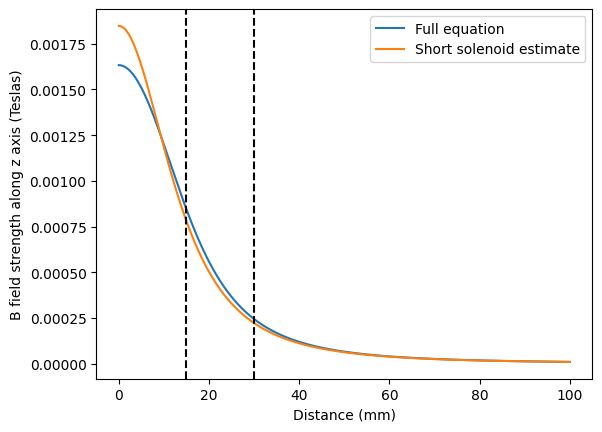

In [3]:
mu_0 = 1 * units.vacuum_permeability
N = 100
l = 18 * units.millimeter
R = 34 * units.millimeter / 2
z = np.linspace(0 * units.mm, 100 * units.mm, 1000)
I = 0.5 * units.amp

B_z_axis = mu_0 * N * I / 2 * (((l / 2 - z) / (l * np.sqrt(R ** 2 + (l / 2 - z) ** 2))) + ((l / 2 + z) / (l * np.sqrt(R ** 2 + (l / 2 + z) ** 2))))
print(B_z_axis[0].to(units.tesla))

# From wikipedia: https://en.wikipedia.org/wiki/Solenoid#Short_solenoid_estimate
B_short_solenoid_eq = mu_0 * I * N * R ** 2 / (2 * (R ** 2 + z ** 2) ** (3 / 2))

start_lin_reg = 15 * units.mm
end_lin_reg = 30 * units.mm
lin_reg_range = (start_lin_reg <= z) & (z <= end_lin_reg)

plt.plot(z.to(units.mm), B_z_axis.to(units.tesla), label = "Full equation")
plt.plot(z.to(units.mm), B_short_solenoid_eq.to(units.tesla), label = "Short solenoid estimate")
plt.xlabel("Distance (mm)")
plt.ylabel("B field strength along z axis (Teslas)")
plt.axvline(x = start_lin_reg.to(units.mm).magnitude, color = "black", linestyle = "dashed")
plt.axvline(x = end_lin_reg.to(units.mm).magnitude, color = "black", linestyle = "dashed")
plt.legend(loc = "upper right")

c:\Users\ieykamp\AppData\Local\Programs\Python\Python310\lib\site-packages\pint\facets\plain\quantity.py:998: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


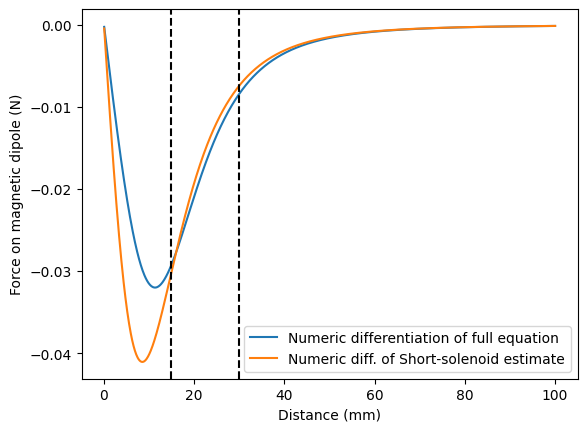

In [4]:
magnet_dipole = 0.44 * units.amp * units.meter ** 2
dBdz = np.diff(B_z_axis, prepend = B_z_axis[0]) / np.diff(z, prepend = z[0])
F = magnet_dipole * dBdz

dBdz_short_solenoid_eq = np.diff(B_short_solenoid_eq, prepend = B_short_solenoid_eq[0]) / np.diff(z, prepend = z[0])
F_short_solenoid_eq = magnet_dipole * dBdz_short_solenoid_eq

# linear regression
A = np.vstack([z[lin_reg_range].to(units.mm).magnitude, np.ones(len(z[lin_reg_range]))]).T
slope, intercept = np.linalg.lstsq(A, F[lin_reg_range].to(units.newton).magnitude, rcond=None)[0]
slope = slope * units.N / units.mm
intercept = intercept * units.newton

plt.plot(z.to(units.mm), F.to(units.newton), label = "Numeric differentiation of full equation")
plt.plot(z.to(units.mm), F_short_solenoid_eq.to(units.newton), linestyle = "solid", label = "Numeric diff. of Short-solenoid estimate")
# plt.plot((z[lin_reg_range]).to(units.mm), (slope * z[lin_reg_range] + intercept).to(units.newton), color = "black", label = "Linear regression")
plt.xlabel("Distance (mm)")
plt.ylabel("Force on magnetic dipole (N)")
plt.axvline(x = start_lin_reg.to(units.mm).magnitude, color = "black", linestyle = "dashed")
plt.axvline(x = end_lin_reg.to(units.mm).magnitude, color = "black", linestyle = "dashed")
plt.legend(loc = "lower right")

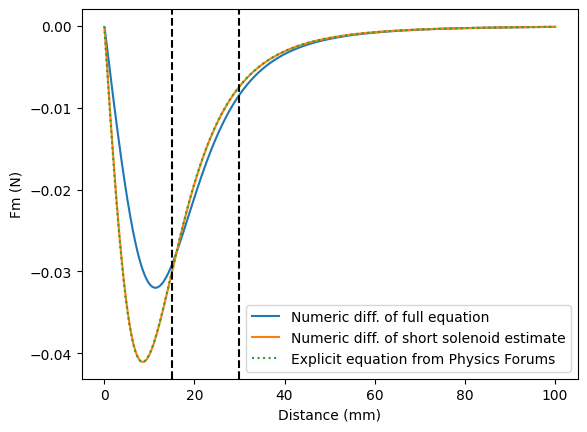

In [5]:
# From: https://www.physicsforums.com/insights/how-to-model-a-magnet-falling-through-a-conducting-pipe/
F2 = -3 * mu_0 * R ** 2 * N * I * z / (2 * (R ** 2 + z ** 2) ** (5 / 2)) * magnet_dipole

plt.plot(z.to(units.mm), F.to(units.newton), label = "Numeric diff. of full equation")
plt.plot(z.to(units.mm), F_short_solenoid_eq.to(units.newton), linestyle = "solid", label = "Numeric diff. of short solenoid estimate")
plt.plot(z.to(units.mm), F2.to(units.newton), linestyle = "dotted", label = "Explicit equation from Physics Forums")
plt.xlabel("Distance (mm)")
plt.ylabel("Fm (N)")
plt.axvline(x = start_lin_reg.to(units.mm).magnitude, color = "black", linestyle = "dashed")
plt.axvline(x = end_lin_reg.to(units.mm).magnitude, color = "black", linestyle = "dashed")
plt.legend(loc = "lower right")

[[1.50e+01] [2.25e+01] [3.00e+01]] mm


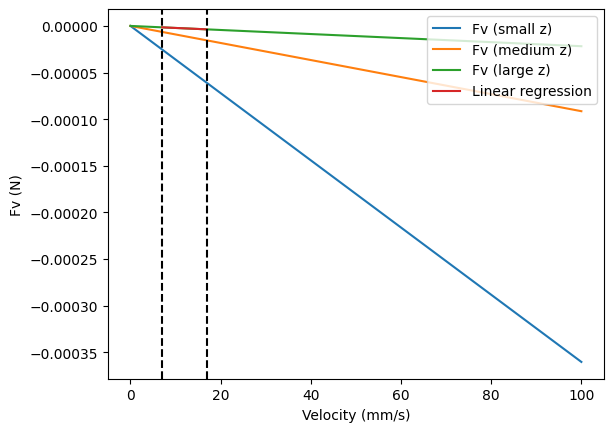

In [8]:
v = np.linspace(0 * units.mm / units.second, 100 * units.mm / units.second, 1000)
z1 = np.array([[start_lin_reg.to(units.mm).magnitude, ((start_lin_reg + end_lin_reg) / 2).to(units.mm).magnitude, end_lin_reg.to(units.mm).magnitude]]).T * units.mm
print(z1)
res = 0.01 * units.ohm
Fv = N * -9 * mu_0 ** 2 * magnet_dipole ** 2 * R ** 4 * z1 ** 2 * v / (4 * res * (R ** 2 + z1 ** 2) ** 5)

start_v_lin_reg = 7 * units.mm / units.s
end_v_lin_reg = 17 * units.mm / units.s
v_lin_reg_range = (start_v_lin_reg <= v) & (v <= end_v_lin_reg)

# linear regression
A = np.vstack([v[v_lin_reg_range].to(units.mm / units.s).magnitude, np.ones(len(v[v_lin_reg_range]))]).T
v_slope, v_intercept = np.linalg.lstsq(A, Fv[2][v_lin_reg_range].to(units.newton).magnitude, rcond=None)[0]
v_slope = v_slope * units.N / (units.mm / units.second)
v_intercept = v_intercept * units.newton

plt.plot(v.to(units.mm / units.second), Fv[0].to(units.newton), label = "Fv (small z)")
plt.plot(v.to(units.mm / units.second), Fv[1].to(units.newton), label = "Fv (medium z)")
plt.plot(v.to(units.mm / units.second), Fv[2].to(units.newton), label = "Fv (large z)")
plt.plot(v[v_lin_reg_range], v[v_lin_reg_range] * v_slope + v_intercept, label = "Linear regression")
plt.xlabel("Velocity (mm/s)")
plt.ylabel("Fv (N)")
plt.axvline(x = start_v_lin_reg.to(units.mm / units.s).magnitude, color = "black", linestyle = "dashed")
plt.axvline(x = end_v_lin_reg.to(units.mm / units.s).magnitude, color = "black", linestyle = "dashed")
plt.legend(loc = "upper right")